# NLP Club: Deep learning with TensorFlow and Keras

In this notebook we'll go through the basics of neural networks and their main components and mechanisms. We'll not focus on the theoretical foundations. A great resource for the foundations is [this course.](https://www.nlpdemystified.org/course/neural-networks-1)

We'll use the tensorflow (tf) framework and utilize Keras, which builds upon tf and offers a pretty easy-to-use API for tf.

This notebook closely follows [this one here.](https://github.com/nitinpunjabi/nlp-demystified/blob/main/notebooks/nlpdemystified_neural_networks_foundations.ipynb)

In [146]:
## Update Spacey and download the small english statistical language model

# !pip install -U spacy==3.*
# !python -m spacy download en_core_web_sm

In [147]:
## import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

# Getting Data

In [148]:
## Get data
reviews = pd.read_csv("../../spotify_review_project/data/final/reviews_clean.csv")

In [149]:
reviews.head()

,Unnamed: 0,Review,Rating,Sentiment
0,0,Great music service the audio is high quality ...,5,positive
1,1,Please ignore previous negative rating This ap...,5,positive
2,2,This popup Get the best Spotify experience on ...,4,positive
3,3,Really buggy and terrible to use as of recently,1,negative
4,4,Dear Spotify why do I get songs that I did not...,1,negative


# Tokenization

In [150]:
## We disable NER and parsing to speed up processing
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [151]:
def spacy_tokenizer(doc):
  return [t.lemma_.lower() for t in nlp(doc) if \
          len(t) > 2 and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.is_alpha]

In [152]:
def preprocess_text(text):
  tokens = spacy_tokenizer(text)
  return "|".join(tokens)

In [153]:
## This takes a few minutes
## There's a non-string entry so we need to convert it with astype to avoid errors
preprocessed_corpus = [preprocess_text(post) for post in reviews.Review.astype(str)]

In [154]:
print(preprocessed_corpus[0])
print(preprocessed_corpus[111])

great|music|service|audio|high|quality|app|easy|use|quick|friendly|support
spotify|literally|account|come|good|music|experience|easy|use|feature|honestly|realize|need|get|recommend|apple|music|aesthetically|pleasing|way|well|feature|spotify|premium|ad|good


In [155]:
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_corpus, reviews.Sentiment, train_size=0.80, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, train_size=0.50, random_state=42)


In [156]:
print("Training Data:", len(train_data))
print("Validation Data:", len(val_data))
print("Test Data:", len(test_data))

Training Data: 49076
Validation Data: 6135
Test Data: 6135


In [157]:
tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split='|', oov_token='OOV')

In [158]:
tokenizer.fit_on_texts(train_data)

In [159]:
#tokenizer.get_config()

In [160]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 23430


# Vectorization

In [161]:
# Vectorize the first post using binary. We're using [:1] here because the 
# tokenizer expects an *array* of sequences.
print(train_data[:1])

# The resulting binary BoW has a 1 set for every word present in the sequence.
binary_bow = tokenizer.texts_to_matrix(train_data[:1])
print(f"Vector shape: {binary_bow.shape}")
print(binary_bow)

['great|podcast']
Vector shape: (1, 23431)
[[0. 0. 0. ... 0. 0. 0.]]


In [162]:
present_tokens = np.where(binary_bow[0] == 1)[0]
print(f"Token indices: {present_tokens}")
print(" ".join(tokenizer.index_word[n] for n in present_tokens))

Token indices: [16 24]
great podcast


In [163]:
tfidf_bow = tokenizer.texts_to_matrix(train_data[:1], mode='tfidf')
print(tfidf_bow, '\n')

# https://numpy.org/doc/stable/user/basics.indexing.html
print(f"TF-IDF scores of the first post's tokens:\n {tfidf_bow[0][present_tokens]}")

[[0. 0. 0. ... 0. 0. 0.]] 

TF-IDF scores of the first post's tokens:
 [2.30488067 2.7415456 ]


In [164]:
## Force to run on CPU to avoid errors
with tf.device('/CPU:0'):
    X_train_bow = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))
    X_train_tfidf = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data, mode='tfidf'))


In [165]:
print("Shape of one-hot BoW:", tf.shape(X_train_bow))
print("Shape of TF-IDF BoW:", tf.shape(X_train_tfidf))

Shape of one-hot BoW: tf.Tensor([49076 23431], shape=(2,), dtype=int32)
Shape of TF-IDF BoW: tf.Tensor([49076 23431], shape=(2,), dtype=int32)


In [166]:
print(train_labels)

27988    positive
32871    negative
44795    negative
38406    negative
30912    negative
           ...   
54343    negative
38158    negative
860      negative
15795    positive
56422    positive
Name: Sentiment, Length: 49076, dtype: object


In [167]:
label_map = {"negative": 0, "positive": 1}
y_train = [label_map[label] for label in train_labels]
y_train = tf.convert_to_tensor(y_train)
print(y_train)
print("Shape of training labels:", y_train.shape)

tf.Tensor([1 0 0 ... 0 1 1], shape=(49076,), dtype=int32)
Shape of training labels: (49076,)


In [168]:
with tf.device('/CPU:0'):
    X_val_bow = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
    X_val_tfidf = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data, mode="tfidf"))
    X_test_bow = tf.sparse.from_dense(tokenizer.texts_to_matrix(test_data))
    X_test_tfidf = tf.sparse.from_dense(tokenizer.texts_to_matrix(test_data, mode="tfidf"))
    
y_val = [label_map[label] for label in val_labels]
y_test = [label_map[label] for label in test_labels]
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

## Model 1: BoW
* 2 fully connected layers with 128 units

In [169]:
NUM_CLASSES = 1 # one binary class
NUM_UNITS = 128

# "set_seed" is called to ensure we get the same weights every time. Comment out this
# line to get different weight initializations.
tf.random.set_seed(42)

# "kernel_initializer" is passed to ensure we get the same weights every time. Remove
# the parameter to get different weight initializations.
model1_bow = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=42))
  ])

In [170]:
model1_bow.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [171]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

with tf.device('/GPU:0'):
    history = model1_bow.fit(X_train_bow, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_bow, y_val))

Epoch 1/15


C:\Users\dominik.freunberger\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_18/dense_20/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_18/dense_20/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_18/dense_20/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


384/384 [==============================] - 4s 8ms/step - loss: 0.3761 - accuracy: 0.8462 - val_loss: 0.3648 - val_accuracy: 0.8507
Epoch 2/15
384/384 [==============================] - 3s 7ms/step - loss: 0.3158 - accuracy: 0.8762 - val_loss: 0.3661 - val_accuracy: 0.8478
Epoch 3/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2949 - accuracy: 0.8858 - val_loss: 0.3756 - val_accuracy: 0.8509
Epoch 4/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2769 - accuracy: 0.8938 - val_loss: 0.3685 - val_accuracy: 0.8510
Epoch 5/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2587 - accuracy: 0.9023 - val_loss: 0.3768 - val_accuracy: 0.8512
Epoch 6/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2395 - accuracy: 0.9114 - val_loss: 0.3883 - val_accuracy: 0.8515
Epoch 7/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2207 - accuracy: 0.9201 - val_loss: 0.3988 - val_accuracy: 0.8487
Epoch 8/15
384/38

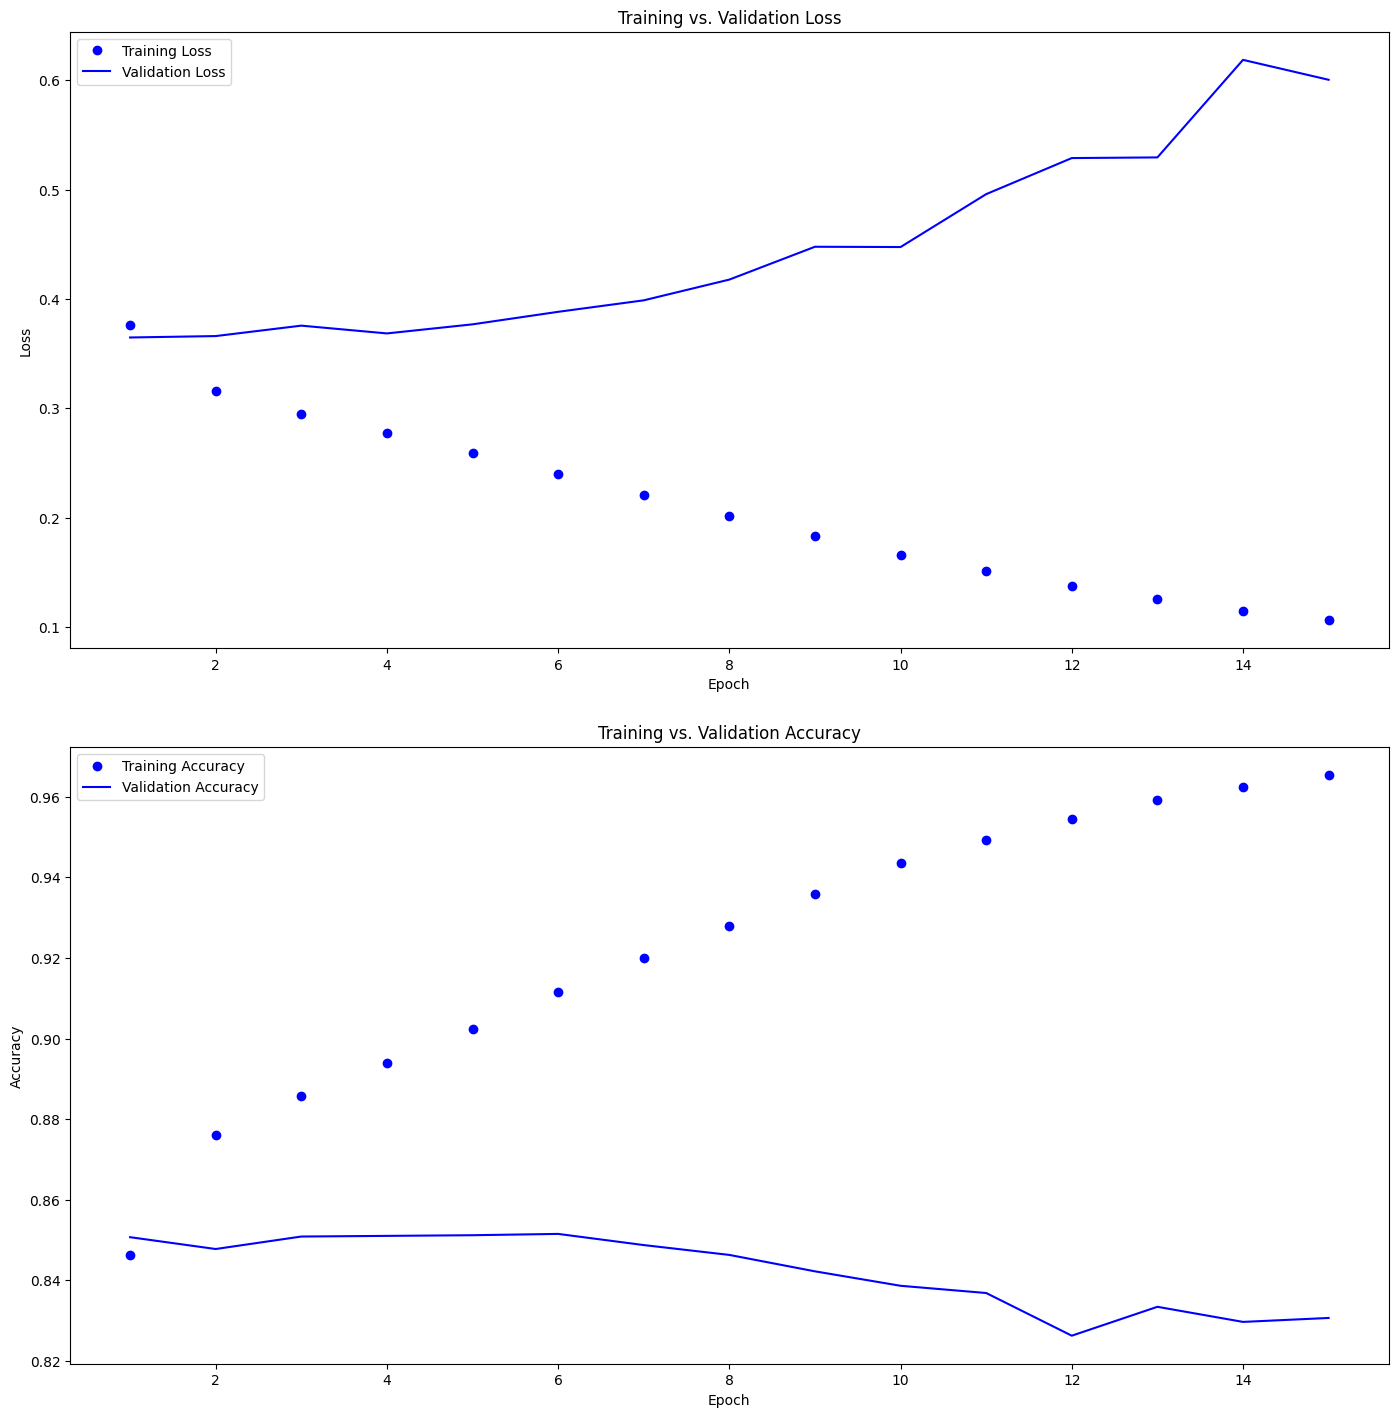

In [172]:
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [173]:
model1_bow.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               2999296   
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,015,937
Trainable params: 3,015,937
Non-trainable params: 0
_________________________________________________________________


In [174]:
# Size of vocabulary. The '+ 1' is because the zero index is reserved for padding.
v = (len(tokenizer.word_index) + 1)
print(f"Size of vocabulary/number of columns in BoW array (v): {v}")

n = NUM_UNITS
print(f"Number of units in the first layer(n): {n}\n")

# The '+ n' accounts for the number of biases. Each unit has one.
p = v * n + n
print(f"Number of params in the first layer(p) = v * n + n = {p}")

Size of vocabulary/number of columns in BoW array (v): 23431
Number of units in the first layer(n): 128

Number of params in the first layer(p) = v * n + n = 2999296


In [175]:
results = model1_bow.evaluate(X_val_bow, y_val)
print(f"Validation loss: {results[0]}")
print(f"Validation accuracy: {results[1]}")

192/192 [==============================] - 1s 3ms/step - loss: 0.6006 - accuracy: 0.8306
Validation loss: 0.600609302520752
Validation accuracy: 0.8306438326835632


In [176]:
y_pred_probs = model1_bow.predict(X_val_bow, verbose=1)
y_pred_probs

192/192 [==============================] - 1s 2ms/step


array([[0.79696226],
       [0.9999782 ],
       [0.13920897],
       ...,
       [0.9084056 ],
       [0.9995751 ],
       [0.98608685]], dtype=float32)

In [177]:
y_preds = (y_pred_probs >= .5).astype(int)
print(y_preds)

[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


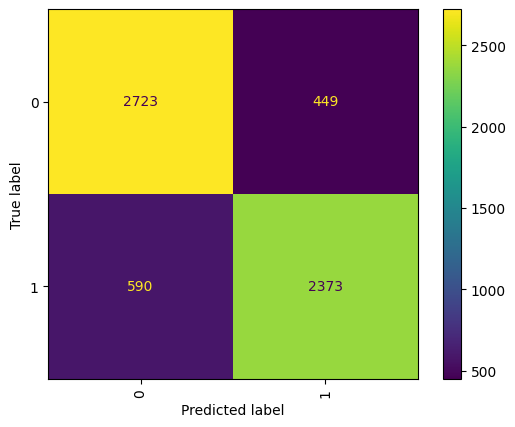

In [178]:
cm = confusion_matrix(y_val, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
cmd.plot(ax=ax, xticks_rotation='vertical')

# Model 1: TF-IDF
* 2 fully connected layers with 128 units


In [179]:
NUM_CLASSES = 1 # one binary class
NUM_UNITS = 128

# "set_seed" is called to ensure we get the same weights every time. Comment out this
# line to get different weight initializations.
tf.random.set_seed(42)

# "kernel_initializer" is passed to ensure we get the same weights every time. Remove
# the parameter to get different weight initializations.
model1_tfidf = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=42))
  ])

In [180]:
model1_tfidf.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [181]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

history = model1_tfidf.fit(X_train_tfidf, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_tfidf, y_val))

Epoch 1/15


C:\Users\dominik.freunberger\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_19/dense_23/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_19/dense_23/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_19/dense_23/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


384/384 [==============================] - 3s 7ms/step - loss: 0.3825 - accuracy: 0.8443 - val_loss: 0.3663 - val_accuracy: 0.8520
Epoch 2/15
384/384 [==============================] - 3s 7ms/step - loss: 0.3068 - accuracy: 0.8834 - val_loss: 0.3760 - val_accuracy: 0.8502
Epoch 3/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2772 - accuracy: 0.8957 - val_loss: 0.3874 - val_accuracy: 0.8544
Epoch 4/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2488 - accuracy: 0.9071 - val_loss: 0.3744 - val_accuracy: 0.8465
Epoch 5/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2206 - accuracy: 0.9183 - val_loss: 0.4008 - val_accuracy: 0.8478
Epoch 6/15
384/384 [==============================] - 3s 7ms/step - loss: 0.1893 - accuracy: 0.9305 - val_loss: 0.4481 - val_accuracy: 0.8424
Epoch 7/15
384/384 [==============================] - 3s 7ms/step - loss: 0.1596 - accuracy: 0.9428 - val_loss: 0.4782 - val_accuracy: 0.8341
Epoch 8/15
384/38

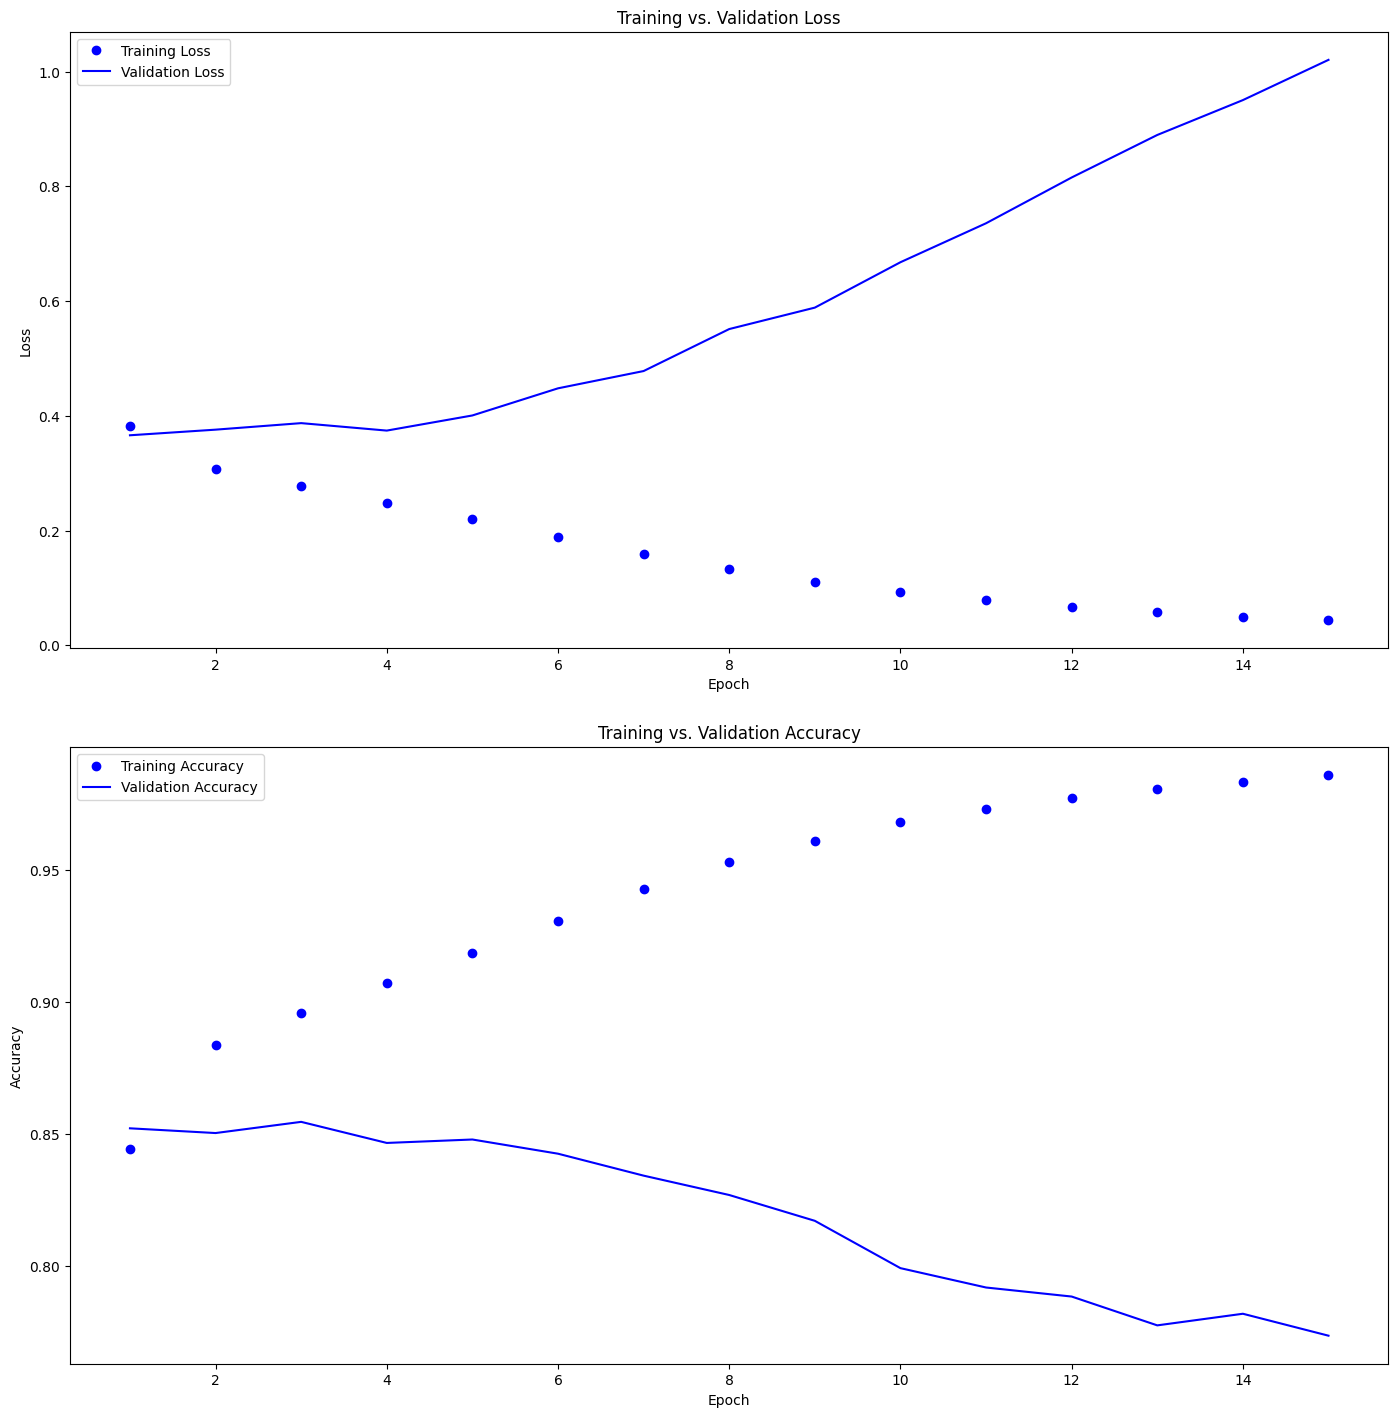

In [182]:

training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [183]:
model1_tfidf.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 128)               2999296   
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,015,937
Trainable params: 3,015,937
Non-trainable params: 0
_________________________________________________________________


In [184]:
results = model1_tfidf.evaluate(X_val_bow, y_val)
print(f"Validation loss: {results[0]}")
print(f"Validation accuracy: {results[1]}")

192/192 [==============================] - 1s 3ms/step - loss: 0.5262 - accuracy: 0.7690
Validation loss: 0.5261641144752502
Validation accuracy: 0.7690301537513733


In [185]:
y_pred_probs = model1_bow.predict(X_val_bow, verbose=1)
y_preds = (y_pred_probs >= .5).astype(int)
print(y_preds)

192/192 [==============================] - 0s 2ms/step
[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


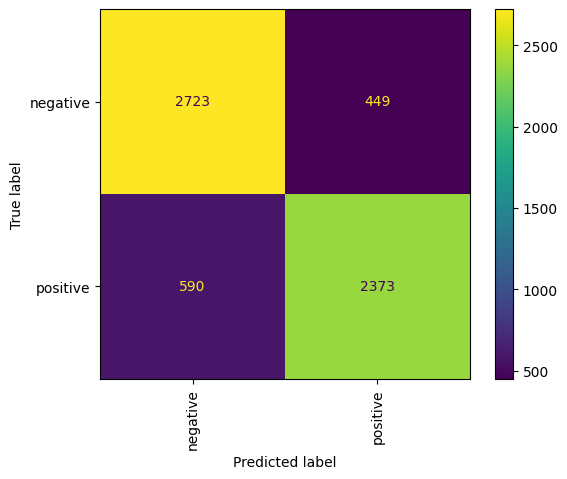

In [186]:
cm = confusion_matrix(y_val, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map)
fig, ax = plt.subplots()
cmd.plot(ax=ax, xticks_rotation='vertical')

# Model 2: BoW
* 3 fully connected layers with 128 units
* Dropout layer
* Early Stopping/Callback

In [187]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

tf.random.set_seed(0)
initializer = tf.keras.initializers.HeNormal(seed=42)

model2_bow = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.3),
  layers.Dense(NUM_CLASSES, activation='sigmoid')
])

model2_bow.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

with tf.device('/GPU:0'):
  history = model2_bow.fit(X_train_bow, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_bow, y_val), callbacks=[es_callback])

Epoch 1/15


C:\Users\dominik.freunberger\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_20/dense_26/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_20/dense_26/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_20/dense_26/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


384/384 [==============================] - 4s 9ms/step - loss: 0.3657 - accuracy: 0.8532 - val_loss: 0.3678 - val_accuracy: 0.8500
Epoch 2/15
384/384 [==============================] - 3s 8ms/step - loss: 0.3110 - accuracy: 0.8786 - val_loss: 0.3587 - val_accuracy: 0.8525
Epoch 3/15
384/384 [==============================] - 3s 8ms/step - loss: 0.2832 - accuracy: 0.8910 - val_loss: 0.3753 - val_accuracy: 0.8561


In [188]:
results = model2_bow.evaluate(X_val_bow, y_val)
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

192/192 [==============================] - 1s 4ms/step - loss: 0.3753 - accuracy: 0.8561
Test loss: 0.3752728998661041
Test accuracy: 0.8560717105865479


In [189]:
y_pred_probs = model2_bow.predict(X_val_bow, verbose=1)
y_preds = (y_pred_probs >= .5).astype(int)

192/192 [==============================] - 1s 3ms/step


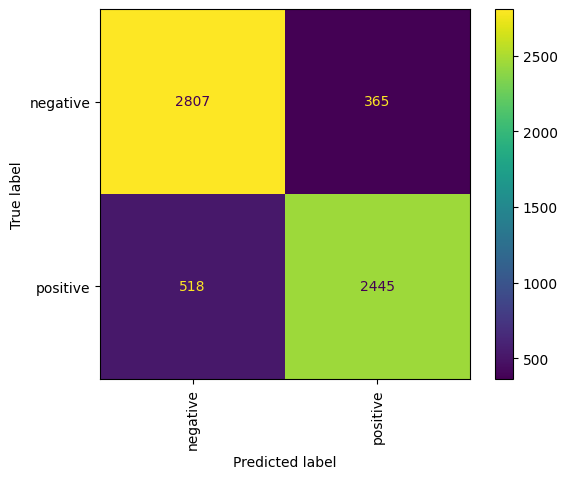

In [190]:
cm = confusion_matrix(y_val, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map)
fig, ax = plt.subplots()
cmd.plot(ax=ax, xticks_rotation='vertical')

In [191]:
print(classification_report(y_val, y_preds, target_names=label_map))

              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      3172
    positive       0.87      0.83      0.85      2963

    accuracy                           0.86      6135
   macro avg       0.86      0.86      0.86      6135
weighted avg       0.86      0.86      0.86      6135



# Model 3: Bidirectional LSTM with embedding layer

In [192]:
# Code target
from tensorflow.keras.utils import to_categorical

def binary_to_categorical(x):
    if x == 'positive':
        return 1
    else:
        return 0

y_binary = reviews.Sentiment.map(binary_to_categorical).to_numpy()
y = to_categorical(y_binary)


In [193]:
# Get reviews
X = reviews.Review.astype(str)

In [194]:
# Train Test Validation Split
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + validation_ratio), 
                                                random_state=42)

In [195]:
sentence_tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=True, oov_token='OOV')

In [196]:
sentence_tokenizer.fit_on_texts(X_train)

In [197]:
print(f"Vocabulary size: {len(sentence_tokenizer.word_index)}")

Vocabulary size: 27050


In [198]:
X_train_seqs = sentence_tokenizer.texts_to_sequences(x_train)

In [199]:
print(X_train_seqs[0])

[5, 7, 47, 14, 99]


In [200]:
print(f"Original: {X_train[0]}")
print(f"Reconstructed: {sentence_tokenizer.sequences_to_texts([X_train_seqs[0]])}")

Original: Great music service the audio is high quality and the app is easy to use Also very quick and friendly support
Reconstructed: ['it is great for podcasts']


In [201]:
X_val_seqs = sentence_tokenizer.texts_to_sequences(X_val)

In [202]:
MAX_LENGTH = len(max(X_train_seqs, key=len))
print(f"Length of longest input sequence: {MAX_LENGTH}")


Length of longest input sequence: 395


In [203]:
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train_seqs, padding='post', maxlen=MAX_LENGTH)

In [204]:
print(X_train_padded[0])

[ 5  7 47 14 99  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [205]:
X_val_padded = keras.preprocessing.sequence.pad_sequences(X_val_seqs, padding='post', maxlen=MAX_LENGTH)

In [206]:
# The one hot encodings for the first label.
print(y_train[0])

[0. 1.]


In [207]:
# For the embedding layer. "+ 1" to account for the padding token.
num_tokens = len(sentence_tokenizer.word_index) + 1
embedding_dim = 128

# For the output layer. The number of classes corresponds to the 
# number of possible tags.
num_classes = 1 + 1

In [208]:
# The set_seed call and kernel_initializer parameters are used here to
# ensure you and I get the same results. To get random weight initializations,
# remove them.
tf.random.set_seed(0)

model3 = keras.Sequential()

model3.add(layers.Embedding(input_dim=num_tokens, 
                           output_dim=embedding_dim, 
                           input_length=MAX_LENGTH,
                           mask_zero=True))

model3.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, 
                                           kernel_initializer=tf.keras.initializers.random_normal(seed=1))))

model3.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False, 
                                           kernel_initializer=tf.keras.initializers.random_normal(seed=1))))

model3.add(layers.Dense(num_classes, activation='softmax', 
                       kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [209]:
model3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 395, 128)          3462528   
                                                                 
 bidirectional_14 (Bidirecti  (None, 395, 256)         263168    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 2)                 514       
                                                                 
Total params: 4,120,450
Trainable params: 4,120,450
Non-trainable params: 0
_________________________________________________________________


In [210]:
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

with tf.device('/GPU:0'):
    history = model3.fit(X_train_padded, y_train, epochs=2, 
                    batch_size=128, validation_data=(X_val_padded, y_val))

Epoch 1/2
384/384 [==============================] - 46s 94ms/step - loss: 0.3434 - accuracy: 0.8569 - val_loss: 0.3294 - val_accuracy: 0.8637
Epoch 2/2
384/384 [==============================] - 33s 87ms/step - loss: 0.2674 - accuracy: 0.8958 - val_loss: 0.3376 - val_accuracy: 0.8657


In [211]:
# # Preprocess the test data and test the model.
X_test_seqs = sentence_tokenizer.texts_to_sequences(X_test)
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test_seqs, padding='post', maxlen=MAX_LENGTH)

In [212]:
model3.evaluate(X_val_padded, y_val)
## Improvement, yay!

192/192 [==============================] - 3s 16ms/step - loss: 0.3376 - accuracy: 0.8657


[0.33758169412612915, 0.865688681602478]

In [213]:
y_pred_probs = model3.predict(x_val_padded, verbose=1)
y_preds = (y_pred_probs >= .5).astype(int)

192/192 [==============================] - 7s 16ms/step


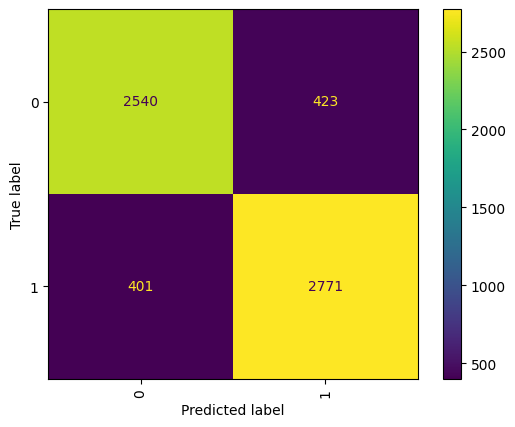

In [214]:
cm = confusion_matrix(y_val[:, 0].reshape(-1, 1), y_preds[:, 0].reshape(-1, 1))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
cmd.plot(ax=ax, xticks_rotation='vertical')

# Model 3 with pretrained embeddings

* Google word vectors (large file!)

In [215]:
# Download "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"

In [216]:
embedding_file = '../../embeddings/GoogleNews-vectors-negative300.bin.gz'

In [217]:
# Get 1M vectors through gensim
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True, limit=1000000)

In [218]:
pizza = word_vectors['pizza']
print(f'Vector dimension: {pizza.shape}')

# The embedding for the word 'pizza'.
print(pizza)

Vector dimension: (300,)
[-1.25976562e-01  2.53906250e-02  1.66992188e-01  5.50781250e-01
 -7.66601562e-02  1.28906250e-01  1.02539062e-01 -3.94821167e-04
  1.21582031e-01  4.32128906e-02  1.72851562e-01 -6.83593750e-02
  3.41796875e-01  8.39843750e-02  6.68945312e-02  2.67578125e-01
 -3.71093750e-02 -5.56640625e-02  1.80664062e-01  1.90429688e-02
 -5.07812500e-02  9.03320312e-03  1.76757812e-01  6.49414062e-02
 -6.25000000e-02 -9.42382812e-02 -9.71679688e-02  4.00390625e-01
  1.15234375e-01  1.02539062e-01 -1.86767578e-02 -2.69531250e-01
  1.80664062e-01  1.25000000e-01 -3.17382812e-02 -5.49316406e-02
  3.45703125e-01 -1.57470703e-02  1.82390213e-05  2.07031250e-01
 -1.25976562e-01 -2.83203125e-01  2.00195312e-01  8.34960938e-02
 -4.73632812e-02 -3.11279297e-02 -2.61718750e-01  1.69921875e-01
 -2.02636719e-02  1.53320312e-01 -1.20605469e-01  3.75000000e-01
 -5.68847656e-02 -4.76074219e-03 -1.95312500e-01 -2.03125000e-01
  3.00781250e-01 -1.01074219e-01 -3.18359375e-01 -9.03320312e-02


In [219]:
# Check similarity
print(word_vectors.similarity('smoke', 'fire'))
print(word_vectors.similarity('fire', 'flame'))
print(word_vectors.similarity('flame', 'cheese'))

0.46457896
0.43148065
0.062532805


In [220]:
# Sentence similarity
word_vectors.n_similarity("the cat sleeps all day".split(), "the feline is dreaming most of the time".split())

0.64365196

In [221]:
from sklearn.decomposition import PCA

def display_pca_scatterplot(model, words):        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure()
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', s=128)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

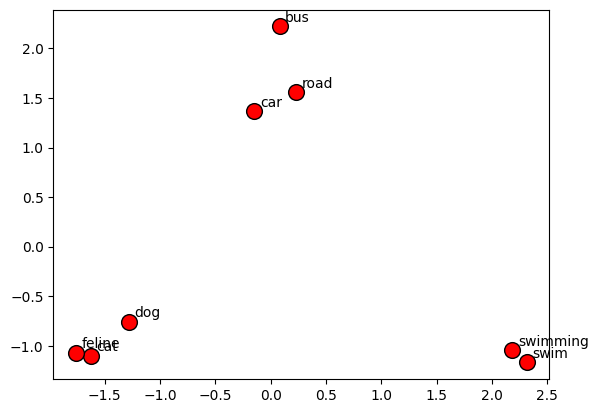

In [222]:
display_pca_scatterplot(word_vectors, ['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus'])


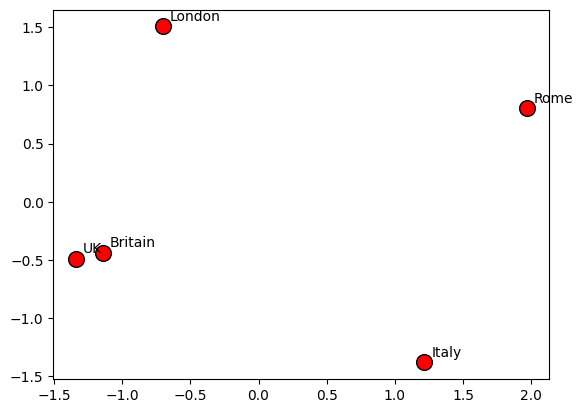

In [223]:
display_pca_scatterplot(word_vectors, ['Rome', 'Italy', 'London', 'Britain', 'UK'])


In [224]:
# Train Test Validation Split
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + validation_ratio), 
                                                random_state=42)

In [225]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000,
                                               filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                                               lower=True)

In [226]:
%%time
tokenizer.fit_on_texts(X_train)

CPU times: total: 984 ms
Wall time: 1.21 s


In [227]:
%%time
import copy
X_train_reviews = copy.deepcopy(X_train)
X_train = tokenizer.texts_to_sequences(X_train_reviews)

CPU times: total: 719 ms
Wall time: 727 ms


In [228]:
# The first review in the training set, vectorized.
print(X_train[0])

[4, 6, 46, 13, 98]


In [229]:
[tokenizer.index_word[x] for x in X_train[0][:10]]

['it', 'is', 'great', 'for', 'podcasts']

In [230]:
# Original review text.
X_train_reviews.iloc[0][:300]

'It is great for podcasts'

In [231]:
MAX_REVIEW_LEN = 200
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_REVIEW_LEN)

In [232]:
# Prepare validation set
X_val_reviews = copy.deepcopy(X_val)
X_val = tokenizer.texts_to_sequences(X_val_reviews)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAX_REVIEW_LEN)

In [233]:
print(tokenizer.word_index['good'])

41


In [234]:
# create this embedding matrix by first initializing a matrix of zeros, then looping over every word in the tokenizer vocabulary and:

# Checking if the word has a corresponding vector in gensim.
# If it does, then copy the vector into the matrix row corresponding to the word's index.

# + 1 to account for padding token.
num_tokens = len(tokenizer.word_index) + 1

# Initialize a matrix of zeroes of size: vocabulary x embedding dimension.
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()

In [235]:
# Quick visual check.
print(embedding_matrix[tokenizer.word_index['good']][:50])

[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891]


In [236]:
## Build model

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True
)

In [237]:
# The set_seed call and kernel_initializer parameters are used here to
# ensure you and I get the same results. To get random weight initializations,
# remove them.
tf.random.set_seed(0)

model3_emb = keras.Sequential()

# This layer will output a sequence of 300-dimension *vectors*, one for each element in the input sequence.
model3_emb.add(embedding_layer)

# This layer will calculate an average of those vectors.
model3_emb.add(layers.GlobalAveragePooling1D())

model3_emb.add(layers.Reshape((-1, 300), input_shape=(None, 300)))

model3_emb.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, 
                                           kernel_initializer=tf.keras.initializers.random_normal(seed=1))))

model3_emb.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False, 
                                           kernel_initializer=tf.keras.initializers.random_normal(seed=1))))

model3_emb.add(layers.Dense(num_classes, activation='softmax', 
                       kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model3_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [238]:
model3_emb.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 300)          8115000   
                                                                 
 global_average_pooling1d_11  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 reshape_3 (Reshape)         (None, 1, 300)            0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 1, 256)           439296    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                     

In [239]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

with tf.device('/GPU:0'):
    history = model3_emb.fit(X_train, y_train, epochs=20,
                    batch_size=128, validation_data=(X_val, y_val),
                     callbacks=[es_callback])

Epoch 1/20
384/384 [==============================] - 12s 21ms/step - loss: 0.4056 - accuracy: 0.8166 - val_loss: 0.3465 - val_accuracy: 0.8541
Epoch 2/20
384/384 [==============================] - 7s 18ms/step - loss: 0.3003 - accuracy: 0.8812 - val_loss: 0.3338 - val_accuracy: 0.8615
Epoch 3/20
384/384 [==============================] - 7s 18ms/step - loss: 0.2778 - accuracy: 0.8914 - val_loss: 0.3558 - val_accuracy: 0.8587
Epoch 4/20
384/384 [==============================] - 7s 18ms/step - loss: 0.2598 - accuracy: 0.8965 - val_loss: 0.3781 - val_accuracy: 0.8463
Epoch 5/20
384/384 [==============================] - 7s 19ms/step - loss: 0.2465 - accuracy: 0.9010 - val_loss: 0.3483 - val_accuracy: 0.8618


In [240]:
model3_emb.evaluate(X_val, y_val)

192/192 [==============================] - 1s 5ms/step - loss: 0.3483 - accuracy: 0.8618


[0.34825262427330017, 0.8617767095565796]

In [241]:
y_pred_probs = model3_emb.predict(X_val, verbose=1)
y_preds = (y_pred_probs >= .5).astype(int)

192/192 [==============================] - 2s 4ms/step


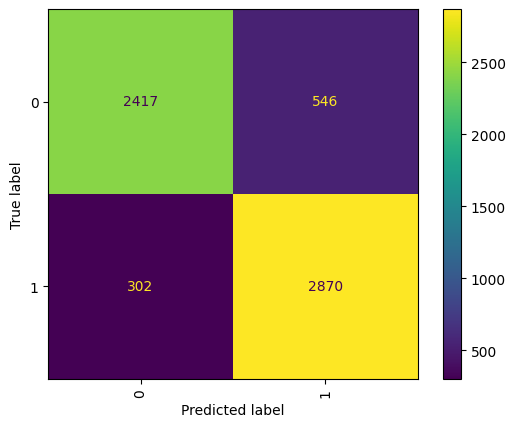

In [242]:
cm = confusion_matrix(y_val[:, 0].reshape(-1, 1), y_preds[:, 0].reshape(-1, 1))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
cmd.plot(ax=ax, xticks_rotation='vertical')

### Test best model on unseen test set


In [243]:
best_model = model3

In [244]:
best_model.evaluate(X_test_padded, y_test)

192/192 [==============================] - 4s 17ms/step - loss: 0.3229 - accuracy: 0.8634


[0.3228710889816284, 0.8634066581726074]

**86.3%** on the unseen test set, pretty good, but mind our [logistic regression score of **87.4%**.](https://www.kaggle.com/code/dominikfreunberger/simpler-is-better-sentiment-classification)